## Naver Movie 평점과 140자평 자료를 활용한 감성 분석

Naver Movie에서 진행하는 140자평과 평점자료를 활용하여 10가지 감성을 세부적으로 분석 시도후 감성을 축소하여 분석 진행

https://movie.naver.com/


Web Crawling

---

### Import

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
import requests
import pandas as pd 
from bs4 import BeautifulSoup
import glob

---

### Web Crawling

In [10]:
# 전체 데이터 갯수를 가져오는 함수
def get_total(num):
    url = "https://movie.naver.com/movie/point/af/list.nhn?&page="+str(num)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, "html.parser")
    return dom.select_one(".h5_right_txt strong").text

# 테스트 코드
get_total(1)

'10634913'

___

In [11]:
# 아이템 리스트를 가져오는 함수
def get_items(num):
    url = "https://movie.naver.com/movie/point/af/list.nhn?&page="+str(num)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, "html.parser")
    return dom.select(".list_netizen tbody tr")

# 테스트 코드
items = get_items(1)    
len(items)

10

In [12]:
# 아이템을 데이터 리스트로 만드는 함수
def make_datas(items):

    datas = []
    
    for item in items:
        
        try:
            point = item.select_one(".point").text             # 평점
            name = item.select_one(".title .movie").text       # 영화 제목
            con = item.select_one(".title").text               # 평
            number = item.select_one(".num").text              # 시간
            datas.append([point, name, con, number]) 

        except Exception as e:
            print(e)
            pass
        

    return datas

# 테스트 코드
datas = make_datas(items)
len(datas)

10

In [ ]:
# 키워드를 입력받아 전체 데이터를 가져오는 함수
def all_datas():
    total = 10000
    pages = int(total) // 10 + 1
    datas = []
    for page in range(1, pages + 1):
        items = get_items(page)
        datas += make_datas(items)
    return datas

# 테스트 코드
datas = all_datas()
len(datas)

In [ ]:
# 데이터 프레임을 만드는 코드
datas = all_datas()

columns = ['Point', 'Name', 'Con', 'Number']
df = pd.DataFrame(datas, columns=columns)
df

In [ ]:
df.to_csv("navermoviedf.csv", index=False)

---

### 1. 데이터 전처리 

(2018년 4월 20일 23:30분경 크롤링 실시한 1만개 자료 (최대1만개까지 웹크롤링 가능))

In [3]:
def pre_data():
    
    df = pd.read_csv("navermoviedf.csv")
    
    # regex를 활용해 문구 정리
    def remove(word):
        word = re.sub("\t신고\n", "", word)
        word = re.sub("\n", "", word)
        word = re.sub("\r", "", word)
        word = re.sub("\t", "", word)
        return word
    
    # remove 함수 적용
    df['Con'] = df['Con'].apply(remove)
    
    # 영화 이름 list로 정리
    a = []
    for i in range(len(df)):
        a.append(df.Name[i])
    
    # 영화 이름 for문으로 하나하나 일치되는 문구 정리
    def remove2(word):
        for j in range(len(df)):
            word = re.sub(a[j], "", word)
        return word
    
    # remeve2 함수 적용
    df['Con'] = df['Con'].apply(remove2)
    
    # make csv
    df.to_csv("navermoviefinaldf.csv", index=False)

    df
    
    return df

df = pre_data()

In [4]:
df.tail()

,Point,Name,Con,Number
9995,2,월요일이 사라졌다,나쁜놈들 혼자보기 아까워서 혜자별점 줬냐 ㅋㅋㅋ리 영화 공상 과학영화다 참...,14011799
9996,6,지금 만나러 갑니다,유머하고 감동받는 영화입니다,14011798
9997,8,그렘린,정말 재미있다. 그래서 아이들한테 보여주고 싶다.,14011796
9998,10,"그날, 바다",영화보는내내 충격이였다 울고오진않을까..걱정되어 준비해간 휴지는 하나도 쓰지를 않았...,14011794
9999,4,램페이지,걍 그럼 솔직히 지루했음,14011792


---

### 2-1. 분석

(MultinomialNB 분석 / 총 140자평으로 10가지 평점 분석)

In [3]:
# Data road

fdf = pd.read_csv("navermoviefinaldf.csv")

In [4]:
fdf.tail()

,Point,Name,Con,Number
9995,2,월요일이 사라졌다,나쁜놈들 혼자보기 아까워서 혜자별점 줬냐 ㅋㅋㅋ리 영화 공상 과학영화다 참...,14011799
9996,6,지금 만나러 갑니다,유머하고 감동받는 영화입니다,14011798
9997,8,그렘린,정말 재미있다. 그래서 아이들한테 보여주고 싶다.,14011796
9998,10,"그날, 바다",영화보는내내 충격이였다 울고오진않을까..걱정되어 준비해간 휴지는 하나도 쓰지를 않았...,14011794
9999,4,램페이지,걍 그럼 솔직히 지루했음,14011792


In [3]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [4]:
# Pipeline 구축

clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [5]:
# 데이터 split

X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(fdf['Con'], fdf['Point'], \
                                                    test_size=0.4, random_state=0)

len(X_train_F),len(X_test_F),len(y_train_F),len(y_test_F)

(6000, 4000, 6000, 4000)

Train 

Train confusion_matrix 

[[ 591    1    0    0    0    0    0    0    0    1]
 [   0  191    0    0    0    0    0    1    0    0]
 [   0    0   56    0    0    0    0    0    0    0]
 [   0    0    0  128    0    0    0    0    0    0]
 [   0    0    0    0  102    0    0    0    0    0]
 [   0    0    0    0    0  323    0    1    0    0]
 [   0    0    0    0    0    0  257    1    0    0]
 [   0    0    0    0    0    0    0  610    0    5]
 [   0    0    0    0    0    0    0    1  370    2]
 [   0    0    0    0    0    1    0    4    0 3354]] 


Train classification_report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       593
          2       0.99      0.99      0.99       192
          3       1.00      1.00      1.00        56
          4       1.00      1.00      1.00       128
          5       1.00      1.00      1.00       102
          6       1.00      1.00      1.00       324
          7       1.00      1.0

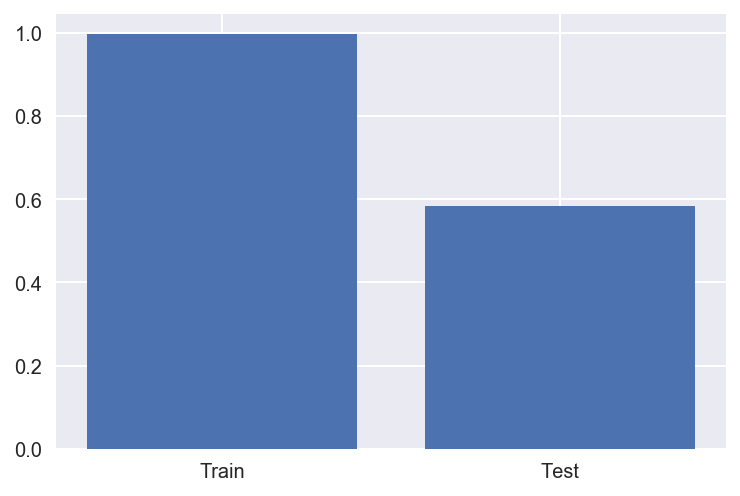

In [6]:
# def naver_movie():
model_F = clf.fit(X_train_F, y_train_F)

y_pred_F = model_F.predict(X_train_F)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_F, y_pred_F), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_F, y_pred_F), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_F, y_pred_F), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_F_T = model_F.predict(X_test_F)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_F, y_pred_F_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_F, y_pred_F_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_F, y_pred_F_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_F, y_pred_F), accuracy_score(y_test_F, y_pred_F_T)
plt.bar(x,y)
plt.show()

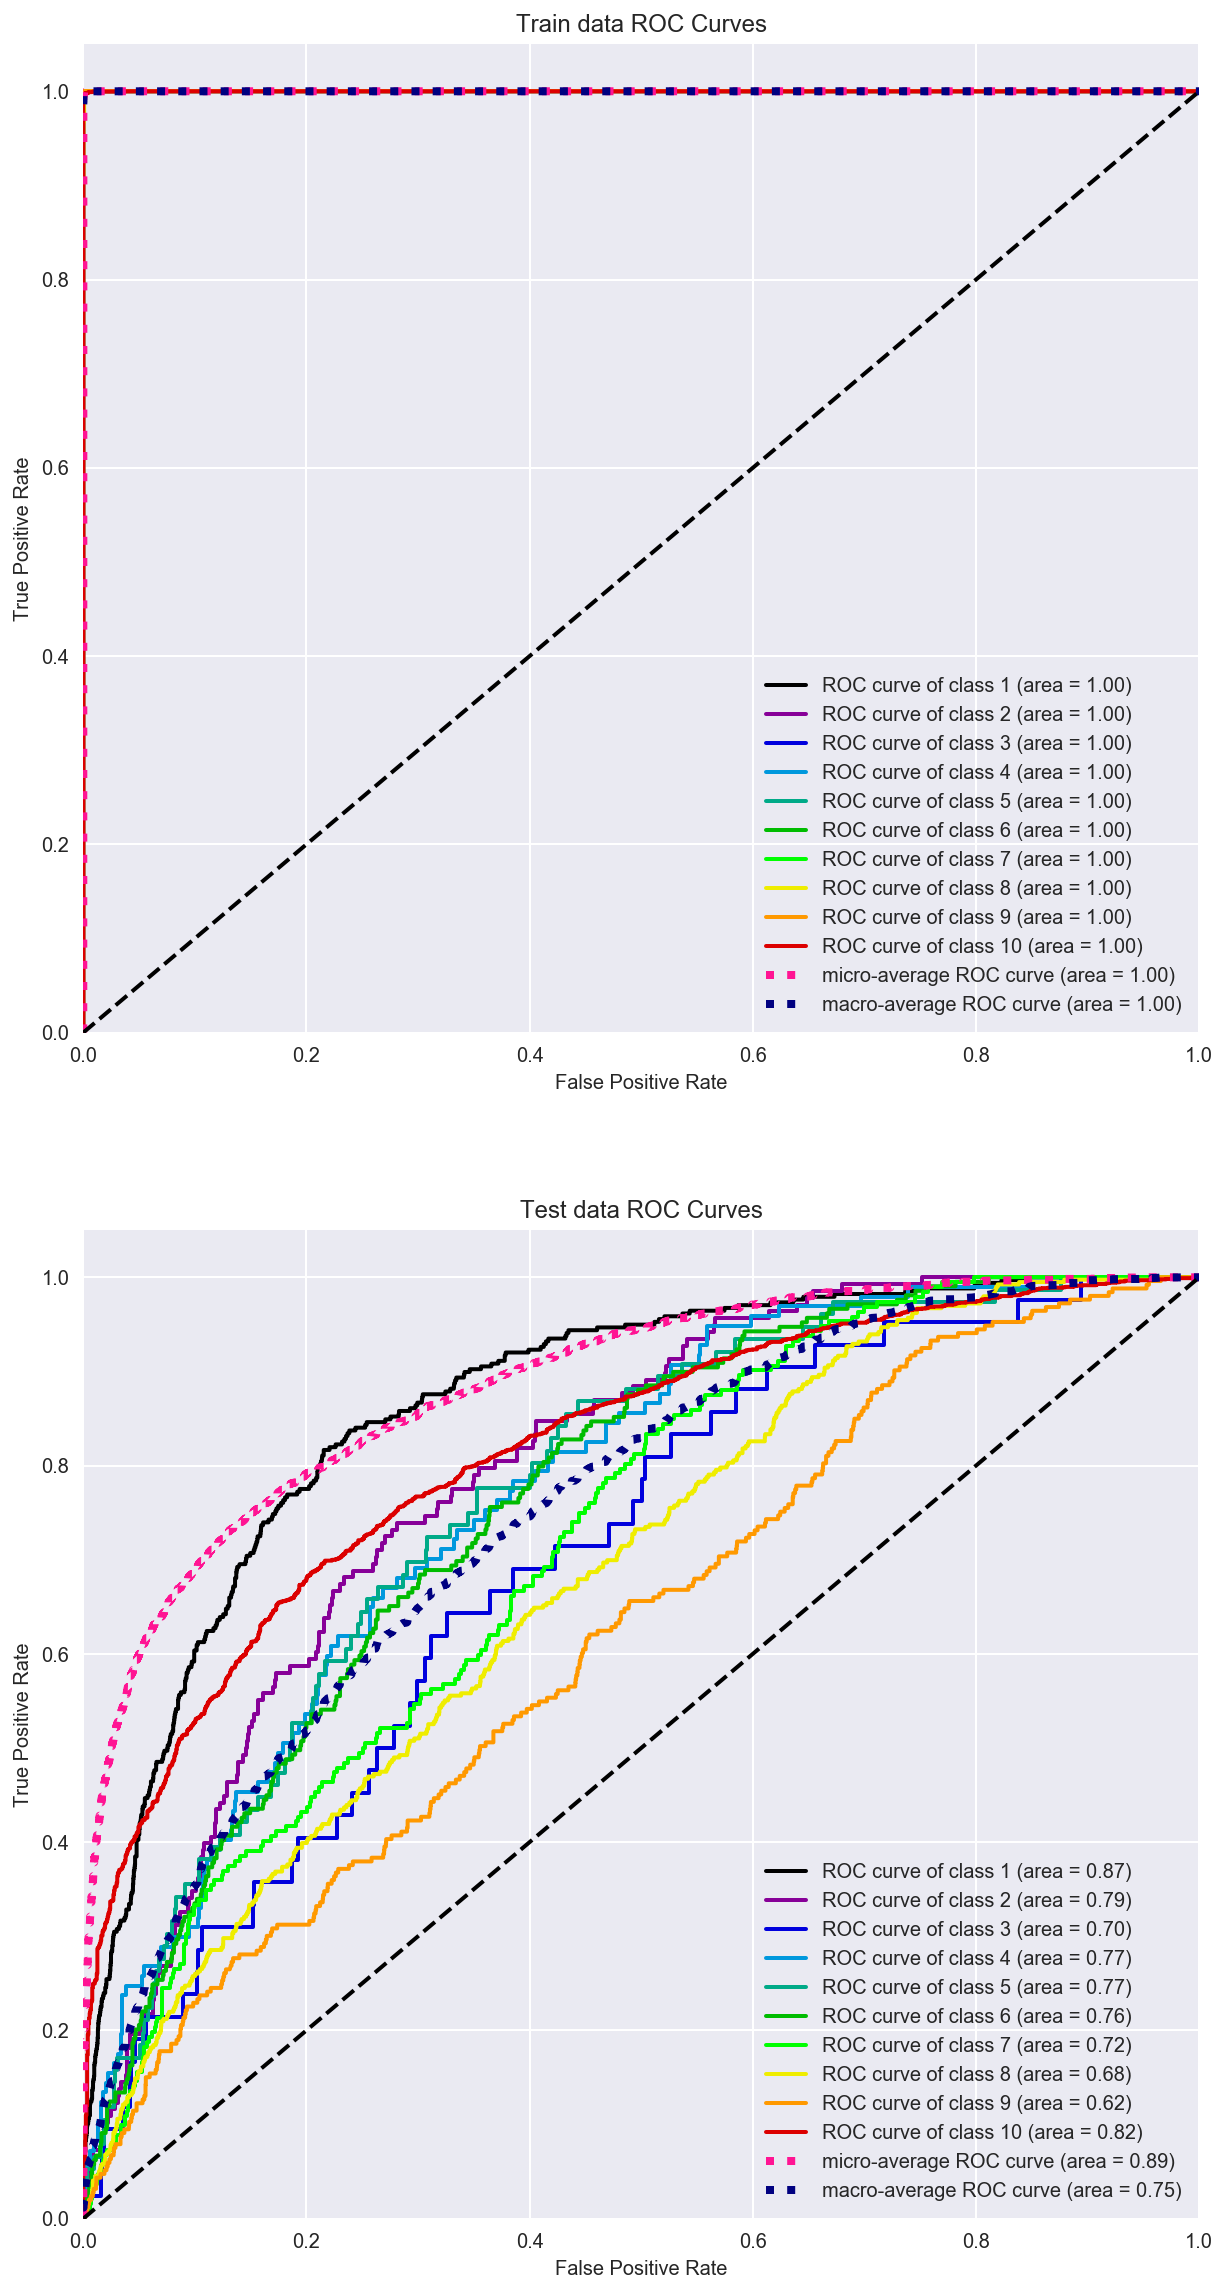

In [7]:
# ROC 민감도 체크

import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_F.predict_proba(X_train_F)
y_probas_T = model_F.predict_proba(X_test_F)

skplt.metrics.plot_roc_curve(y_train_F, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_F, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### 2-2. CountVectorizer 후 LGBMClassifier 분석 진행

자연어 분석을 CountVectorizer를 활용해 Classification 분석으로 진행

In [3]:
# CountVectorizer

def CountVectorizer_naver_con():
    vect = CountVectorizer()
    vect.fit(fdf['Con'])
    #vect.vocabulary_
    
    trans = vect.transform(fdf['Con']).toarray()
    
   #trans = pd.DataFrame(trans, columns=vect.get_feature_names()).to_string()
    trans = pd.DataFrame(trans)
    
    trans['y'] = fdf['Point']
    
    return trans

trans = CountVectorizer_naver_con()

In [4]:
trans.tail()

,0,1,2,3,4,5,6,7,8,9,...,38781,38782,38783,38784,38785,38786,38787,38788,38789,y
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
9999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
# Parameter 조절하며 log-loss 체크

le = LabelEncoder()

y_train = le.fit_transform(trans['y'])
X_train = trans.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

In [5]:
# 데이터 split

X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(trans.drop("y", axis=1), trans['y'], \
                                                    test_size=0.4, random_state=0)

len(X_train_T),len(X_test_T),len(y_train_T),len(y_test_T)

(6000, 4000, 6000, 4000)

Train 

Confusion_Matrix 

[[  76    0    0    0    0    0    0    9    0  508]
 [   9    9    0    0    0    4    1    4    0  165]
 [   3    0    3    0    0    0    1    2    0   47]
 [   6    0    0    3    0    2    1    5    0  111]
 [   2    0    0    0    6    2    1    3    0   88]
 [  10    1    0    0    0   21    0   14    1  277]
 [   4    1    0    0    0    3   19    9    1  221]
 [   2    1    0    1    0    1    0   79    2  529]
 [   3    0    0    0    0    0    1   13   34  322]
 [  31    0    0    0    0    3    0   17    1 3307]] 


Classification_Report 

             precision    recall  f1-score   support

          1       0.52      0.13      0.21       593
          2       0.75      0.05      0.09       192
          3       1.00      0.05      0.10        56
          4       0.75      0.02      0.05       128
          5       1.00      0.06      0.11       102
          6       0.58      0.06      0.12       324
          7       0.79      0.07      0.13 

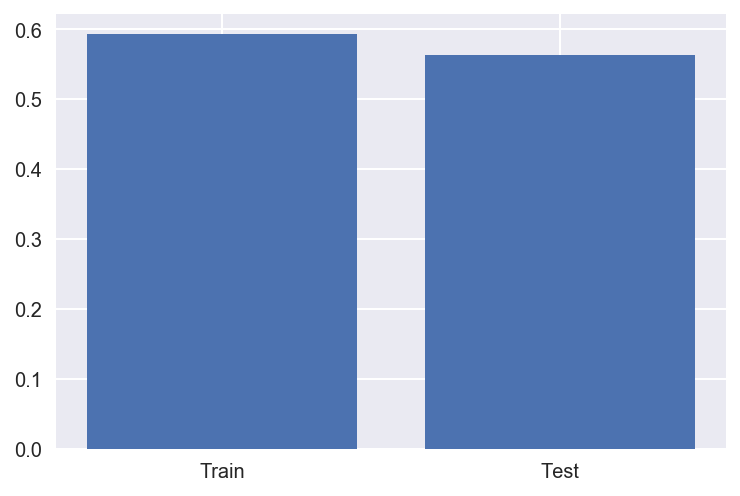

In [8]:
# def naver_movie_lgb():
    
model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
model_lgb.fit(X_train_T, y_train_T)

y_pred_l = model_lgb.predict(X_train_T)

print("Train", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_train_T, y_pred_l), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_train_T, y_pred_l), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_train_T, y_pred_l),2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_l_T = model_lgb.predict(X_test_T)

print("Test", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_test_T, y_pred_l_T), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_test_T, y_pred_l_T), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_test_T, y_pred_l_T),2))

x="Train","Test"
y=accuracy_score(y_train_T, y_pred_l), accuracy_score(y_test_T, y_pred_l_T)
plt.bar(x,y)
plt.show()

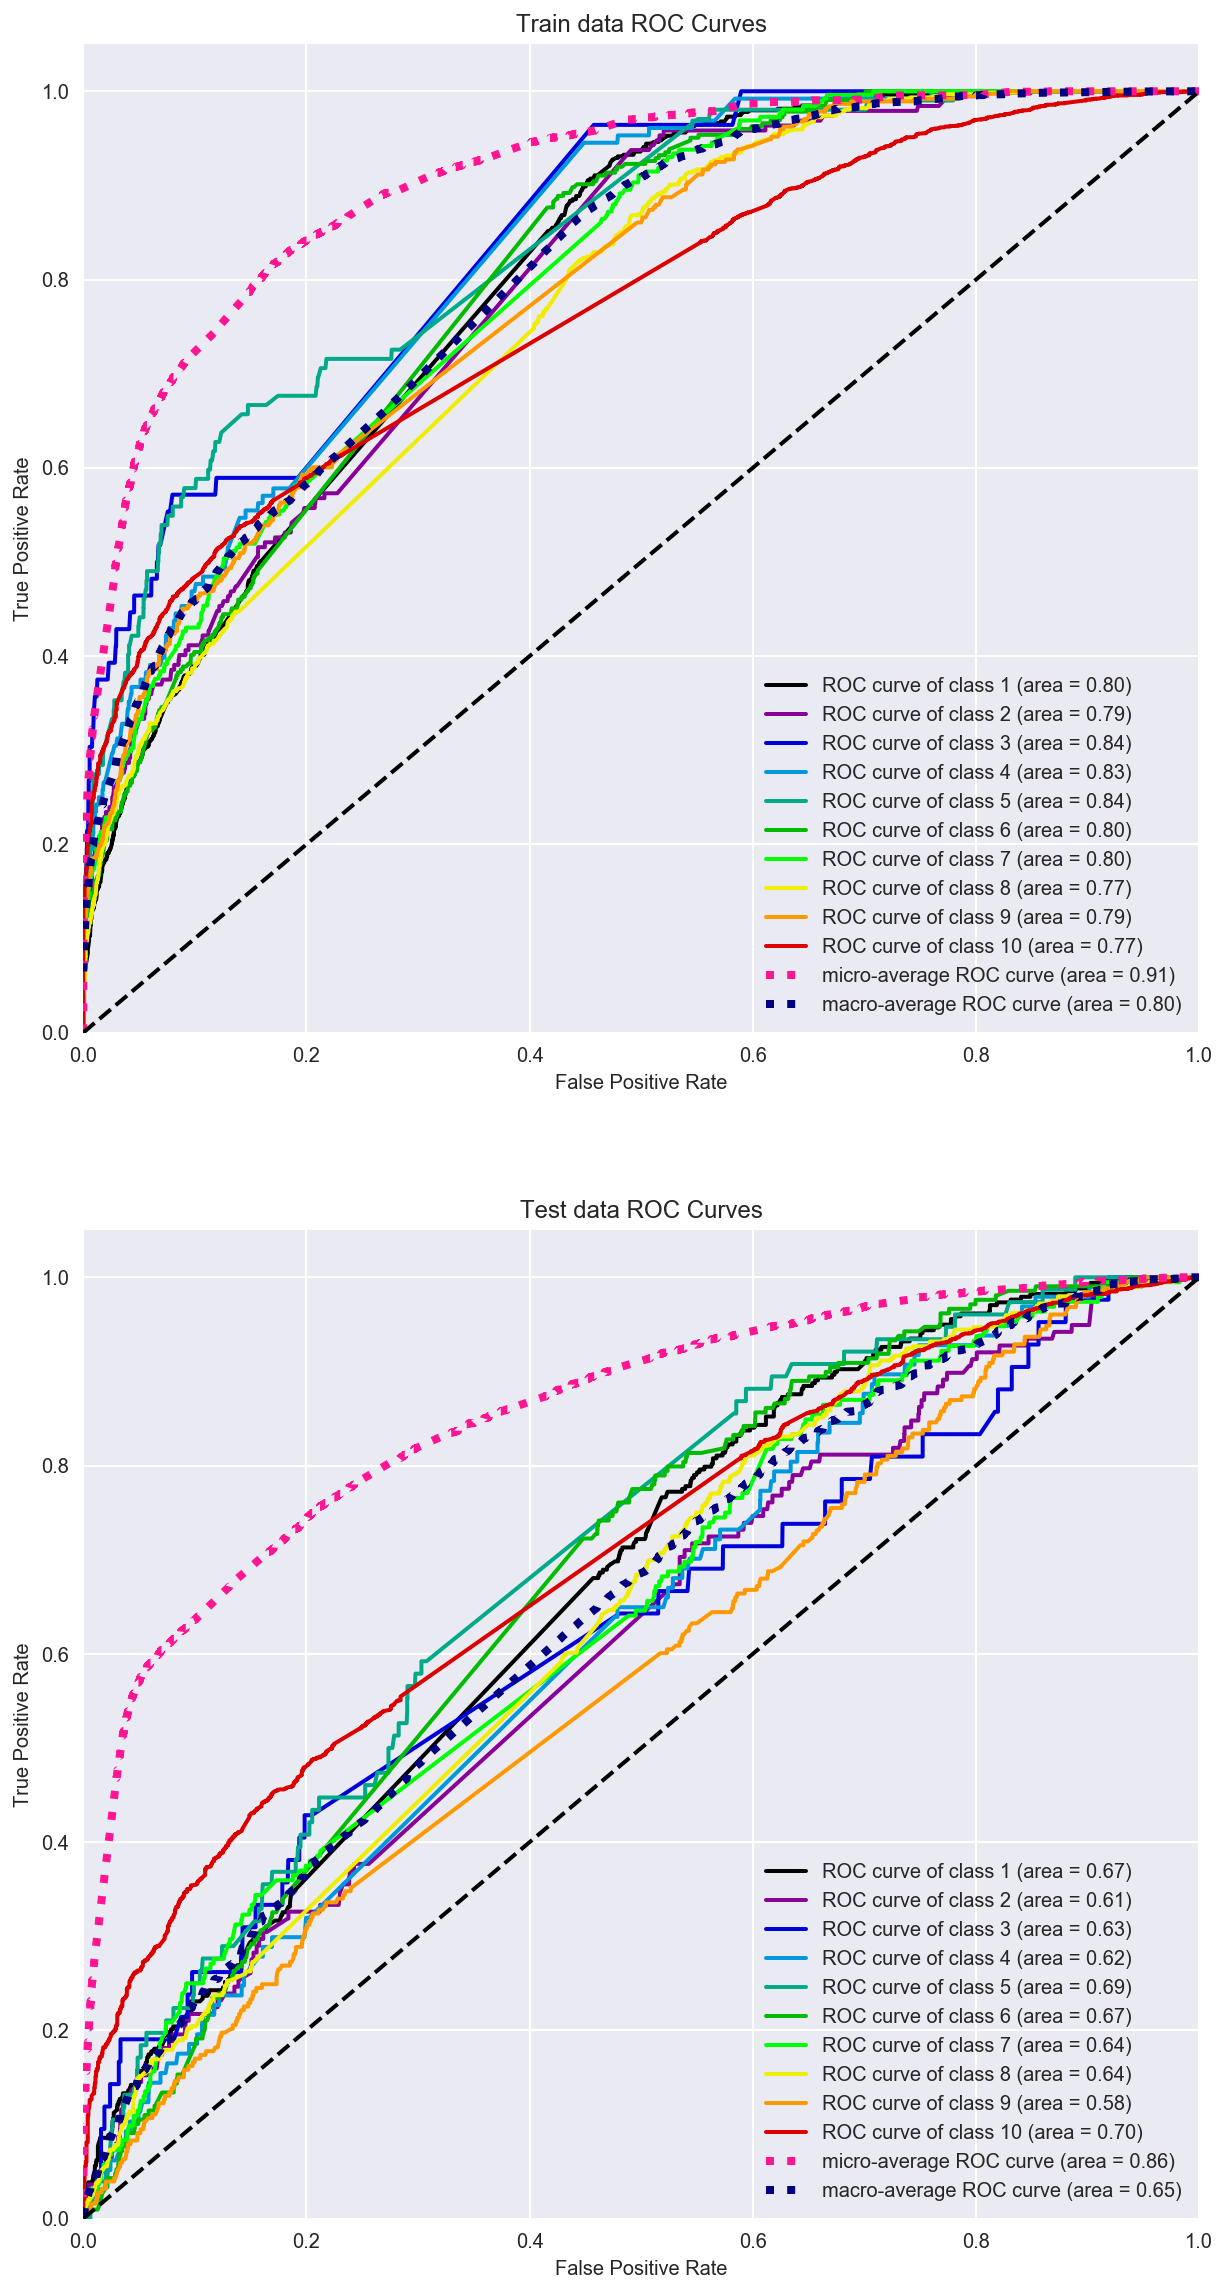

In [9]:
# ROC 민감도 체크

import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_lgb.predict_proba(X_train_T)
y_probas_T = model_lgb.predict_proba(X_test_T)

skplt.metrics.plot_roc_curve(y_train_T, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_T, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### 3-1. 감성 축소 ( 0 =비호감 or 1 =호감 )

10개에서 2개로 감성 축소 진행 (1,2,3 -> 0 / 8,9,10 -> 1)

In [5]:
# 감성 축소

def new_category():
    fdf = pd.read_csv("navermoviefinaldf.csv")
    fdfc = fdf[fdf['Point'].isin(["1","2","3","8","9","10"])].reset_index(drop=True)
    fdfc['category'] = fdfc['Point']
    fdfc['category'].replace([1,2,3,8,9,10], ["0","0","0","1","1","1"], inplace=True)
    
    return fdfc

fdfc = new_category()

In [6]:
fdfc.tail()

,Point,Name,Con,Number,category
8609,10,리틀 포레스트,나는 보는 내내 배가 고팠다.,14011801,1
8610,10,"그날, 바다",예고편만 봐도 소름진실이 꼭 드러나기를 바랍니다.,14011800,1
8611,2,월요일이 사라졌다,나쁜놈들 혼자보기 아까워서 혜자별점 줬냐 ㅋㅋㅋ리 영화 공상 과학영화다 참...,14011799,0
8612,8,그렘린,정말 재미있다. 그래서 아이들한테 보여주고 싶다.,14011796,1
8613,10,"그날, 바다",영화보는내내 충격이였다 울고오진않을까..걱정되어 준비해간 휴지는 하나도 쓰지를 않았...,14011794,1


### 3-2. 감성 축소 후 분석

In [7]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [8]:
# Pipeline 구축

clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.05))
])

In [9]:
# 데이터 split

X_train_AF, X_test_AF, y_train_AF, y_test_AF = train_test_split(fdfc['Con'], fdfc['category'], \
                                                    test_size=0.2, random_state=0)

len(X_train_AF),len(X_test_AF),len(y_train_AF),len(y_test_AF)

(6891, 1723, 6891, 1723)

Train 

Train confusion_matrix 

[[1083    4]
 [   1 5803]] 


Train classification_report 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1087
          1       1.00      1.00      1.00      5804

avg / total       1.00      1.00      1.00      6891
 


Train accuracy_score 

1.0 




Test 

Test confusion_matrix 

[[ 106  166]
 [  12 1439]] 


Test classification_report 

             precision    recall  f1-score   support

          0       0.90      0.39      0.54       272
          1       0.90      0.99      0.94      1451

avg / total       0.90      0.90      0.88      1723
 


Test accuracy_score 

0.9 




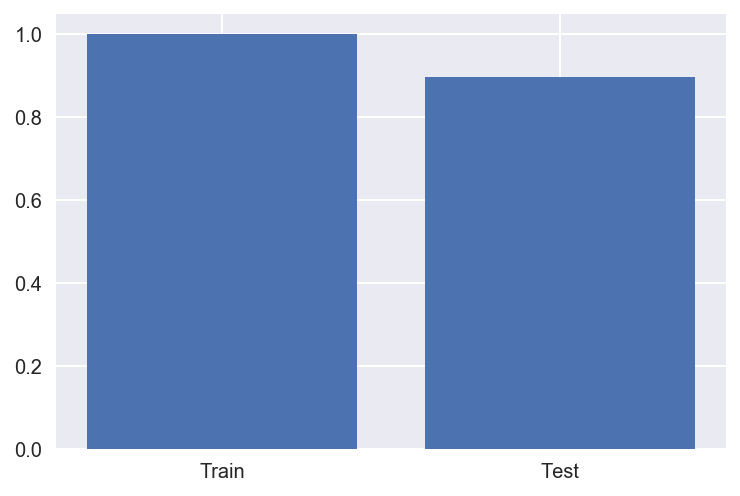

In [10]:
# def naver_movie():
model_AF = clf.fit(X_train_AF, y_train_AF)

y_pred_AF = model_AF.predict(X_train_AF)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_AF, y_pred_AF), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_AF, y_pred_AF), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_AF, y_pred_AF), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_AF_T = model_AF.predict(X_test_AF)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_AF, y_pred_AF_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_AF, y_pred_AF_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_AF, y_pred_AF_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_AF, y_pred_AF), accuracy_score(y_test_AF, y_pred_AF_T)
plt.bar(x,y)
plt.show()

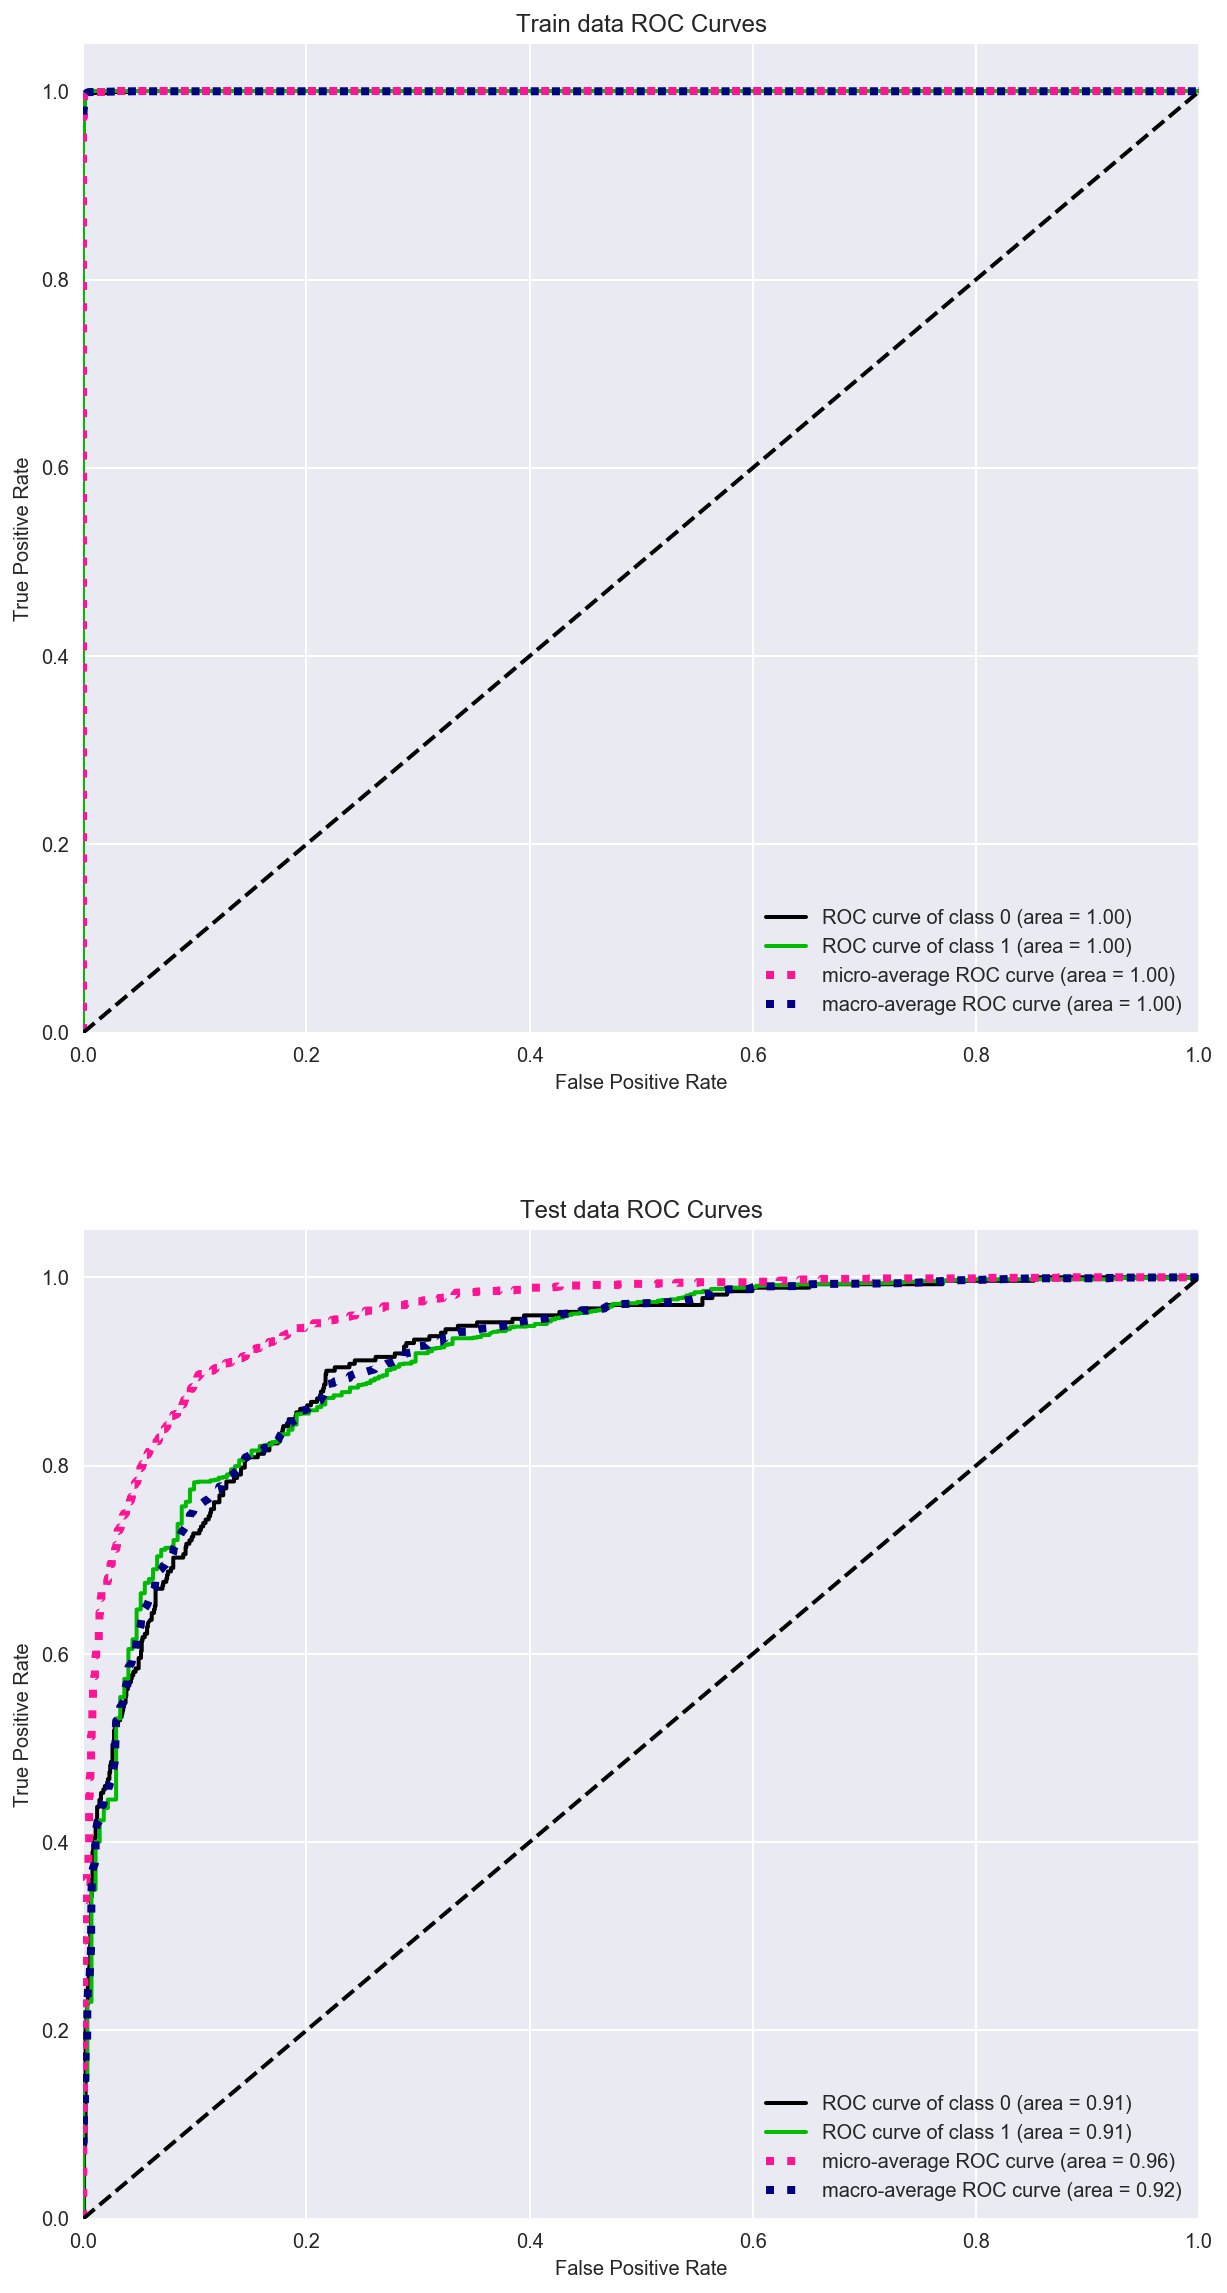

In [16]:
# ROC 민감도 체크

import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_AF.predict_proba(X_train_AF)
y_probas_T = model_AF.predict_proba(X_test_AF)

skplt.metrics.plot_roc_curve(y_train_AF, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_AF, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### 문구 Test

Negative : 0 / Positive : 1

In [11]:
X_=pd.Series("꿀잼")

y_pred_t = model_AF.predict_proba(X_)
y_pred = model_AF.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.04041504 0.95958496]]
['1']


In [13]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model_AF.predict_proba(X_)
y_pred = model_AF.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 노잼
[[0.87296055 0.12703945]]
['0']


---

### 3-3. 감성 축소 후 CountVectorizer 후 LGBMClassifier 분석 진행

자연어 분석을 CountVectorizer를 활용해 Classification 분석으로 진행

In [17]:
# CountVectorizer

def CountVectorizer_naver_con():
    vect = CountVectorizer()
    vect.fit(fdfc['Con'])
    #vect.vocabulary_
    
    trans2 = vect.transform(fdfc['Con']).toarray()
    
   #trans2 = pd.DataFrame(trans2, columns=vect.get_feature_names()).to_string()
    trans2 = pd.DataFrame(trans2)
    
    trans2['y'] = fdfc['category']
    
    return trans2

trans2 = CountVectorizer_naver_con()

In [18]:
trans2.tail()

,0,1,2,3,4,5,6,7,8,9,...,33621,33622,33623,33624,33625,33626,33627,33628,33629,y
8609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Parameter 조절하며 log-loss 체크

le = LabelEncoder()

y_train = le.fit_transform(trans2['y'])
X_train = trans2.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

In [19]:
# 데이터 split

X_train_AT, X_test_AT, y_train_AT, y_test_AT = train_test_split(trans2.drop("y", axis=1), trans2['y'], \
                                                    test_size=0.3, random_state=0)

len(X_train_AT),len(X_test_AT),len(y_train_AT),len(y_test_AT)

(6029, 2585, 6029, 2585)

Train 

Confusion_Matrix 

[[ 161  795]
 [  45 5028]] 


Classification_Report 

             precision    recall  f1-score   support

          0       0.78      0.17      0.28       956
          1       0.86      0.99      0.92      5073

avg / total       0.85      0.86      0.82      6029
 


Accuracy_Score 

0.86 




Test 

Confusion_Matrix 

[[  44  359]
 [  28 2154]] 


Classification_Report 

             precision    recall  f1-score   support

          0       0.61      0.11      0.19       403
          1       0.86      0.99      0.92      2182

avg / total       0.82      0.85      0.80      2585
 


Accuracy_Score 

0.85


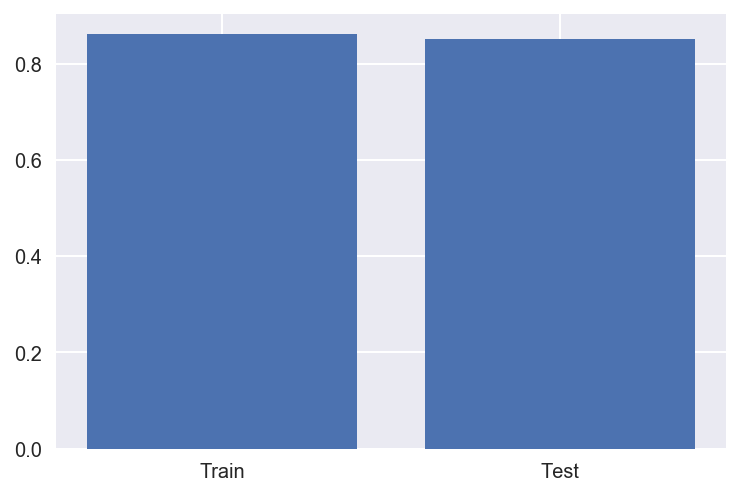

In [20]:
# def naver_movie_lgb():
    
model_lgb_AT = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
model_lgb_AT.fit(X_train_AT, y_train_AT)

y_pred_l_AT = model_lgb_AT.predict(X_train_AT)

print("Train", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_train_AT, y_pred_l_AT), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_train_AT, y_pred_l_AT), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_train_AT, y_pred_l_AT),2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_l_AT_T = model_lgb_AT.predict(X_test_AT)

print("Test", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_test_AT, y_pred_l_AT_T), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_test_AT, y_pred_l_AT_T), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_test_AT, y_pred_l_AT_T),2))

x="Train","Test"
y=accuracy_score(y_train_AT, y_pred_l_AT), accuracy_score(y_test_AT, y_pred_l_AT_T)
plt.bar(x,y)
plt.show()

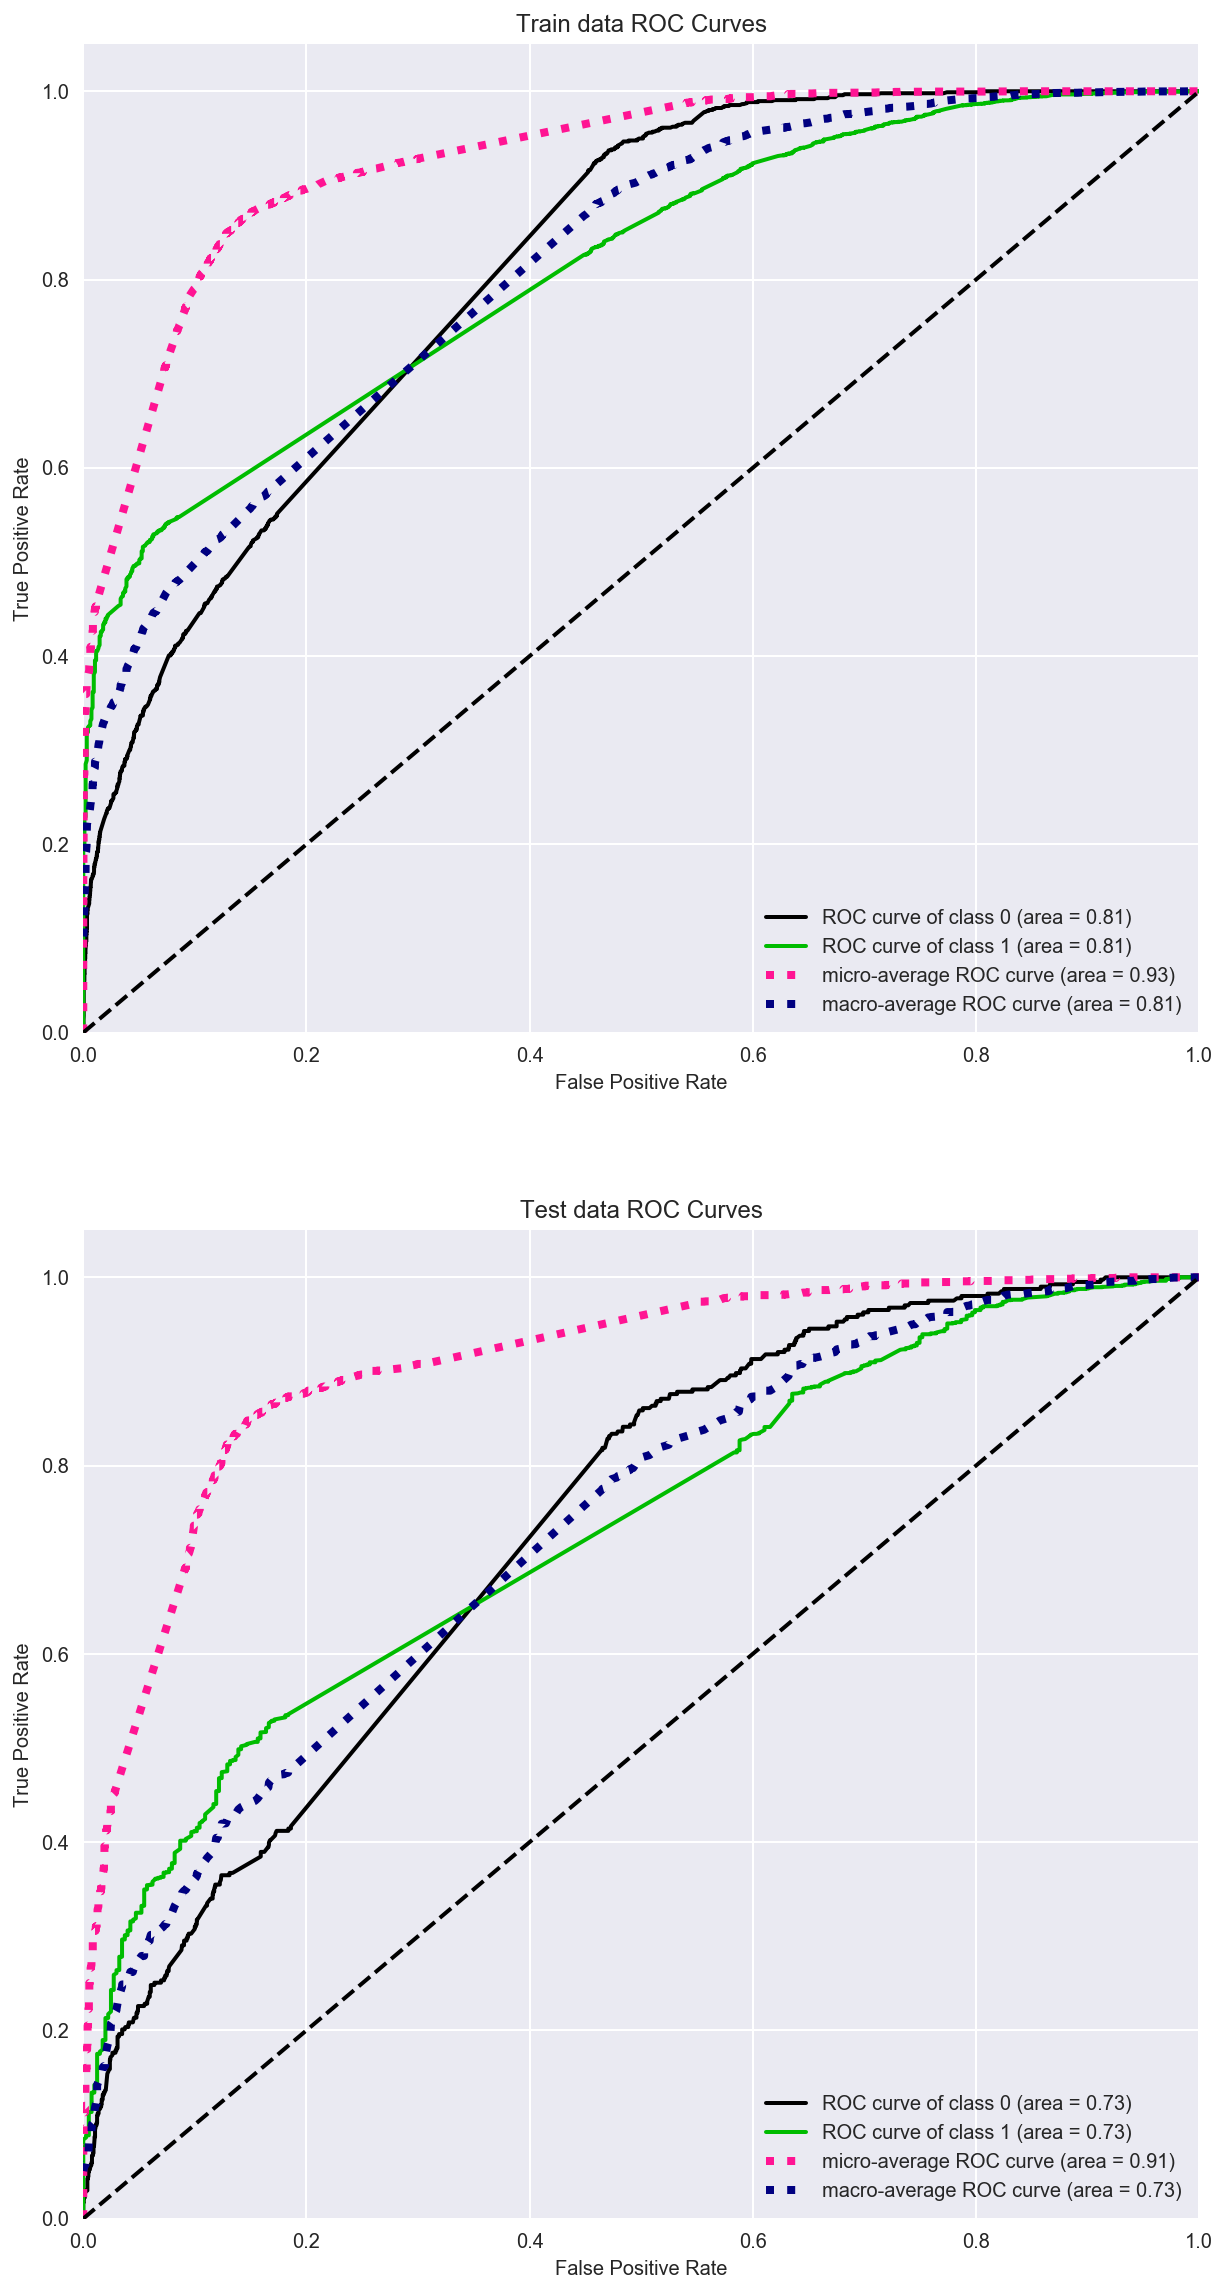

In [21]:
# ROC 민감도 체크

import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_lgb_AT.predict_proba(X_train_AT)
y_probas_T = model_lgb_AT.predict_proba(X_test_AT)

skplt.metrics.plot_roc_curve(y_train_AT, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_AT, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### 보완 필요 사항

데이터 갯수가 10,000개 밖에 없기 때문에 recall 성능이 기대만큼 좋지 않았기 때문에 하단의 코드, https://github.com/e9t/nsmc 와

https://datascienceschool.net/view-notebook/3387abe1784248339e418835297e17d2/ 를 

참조하여 200K개까지 늘려서 분석 진행, 목표는 accuracy_score성능 90% 이상



In [23]:
import urllib
import urllib.request
import urllib.parse
import bs4
import re
import os
import time
from concurrent.futures import ThreadPoolExecutor
 
 
def deleteTag(x):
    return re.sub("<[^>]*>", "", x)
 
 
def getComments(code):
    def makeArgs(code, page):
        params = {
            'code': code,
            'type': 'after',
            'isActualPointWriteExecute': 'false',
            'isMileageSubscriptionAlready': 'false',
            'isMileageSubscriptionReject': 'false',
            'page': page
        }
        return urllib.parse.urlencode(params)
 
    def innerHTML(s, sl=0):
        ret = ''
        for i in s.contents[sl:]:
            if i is str:
                ret += i.strip()
            else:
                ret += str(i)
        return ret
 
    def fText(s):
        if len(s): return innerHTML(s[0]).strip()
        return ''
 
    retList = []
    colSet = set()
    print("Processing: %d" % code)
    page = 1
    while 1:
        try:
            f = urllib.request.urlopen(
                "http://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?" + makeArgs(code, page))
            data = f.read().decode('utf-8')
        except:
            break
        soup = bs4.BeautifulSoup(re.sub("&#(?![0-9])", "", data), "html.parser")
        cs = soup.select(".score_result li")
        if not len(cs): break
        for link in cs:
            try:
                url = link.select('.score_reple em a')[0].get('onclick')
            except:
                print(page)
                print(data)
                raise ""
            m = re.search('[0-9]+', url)
            if m:
                url = m.group(0)
            else:
                url = ''
            if url in colSet: return retList
            colSet.add(url)
            cat = fText(link.select('.star_score em'))
            cont = fText(link.select('.score_reple p'))
            cont = re.sub('<span [^>]+>.+?</span>', '', cont)
            retList.append((url, cat, cont))
        page += 1
 
    return retList
 
 
def fetch(i):
    outname = './con/%d.csv' % i
    try:
        if os.stat(outname).st_size > 0: return
    except:
        None
    rs = getComments(i)
    if not len(rs): return
    f = open(outname, 'w', encoding='utf-8')
    f.write('INSERT IGNORE INTO movie VALUES ')
    for idx, r in enumerate(rs):
        if idx: f.write(',\n')
        f.write("(%d,%s,%s,'%s')" % (i, r[0], r[1], r[2].replace("'", "''").replace("\\", "\\\\")))
    f.write(';\n')
    f.close()
#     time.sleep(1)
 
 
with ThreadPoolExecutor(max_workers=5) as executor:
    for i in range(i, i): #작동중지를위해 임의 처리 i
        executor.submit(fetch, i)


# 출처: http://bab2min.tistory.com/556?category=115012 [나의 큰 O는 logx야..]

NameError: name 'i' is not defined

---

In [24]:
%%time
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2018-04-20 21:35:55--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.88.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.88.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M   574KB/s    in 12s     

2018-04-20 21:36:08 (1.20 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2018-04-20 21:36:08--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.88.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.88.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  

---

### 분석 Setting

Data : 총20만개 

train data : 15만개 / test data : 5만개

분석 진행

In [14]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [15]:
# Pipeline 구축

clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, stop_words=["..", "...", "....", ".....", "~", "~~"], \
                             ngram_range=(1,3), token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")), 
    ("clf", MultinomialNB(alpha=0.05))
])

Train 

Train confusion_matrix 

[[74426   747]
 [  361 74466]] 


Train classification_report 

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     75173
          1       0.99      1.00      0.99     74827

avg / total       0.99      0.99      0.99    150000
 


Train accuracy_score 

0.99 




Test 

Test confusion_matrix 

[[21673  3154]
 [ 3306 21867]] 


Test classification_report 

             precision    recall  f1-score   support

          0       0.87      0.87      0.87     24827
          1       0.87      0.87      0.87     25173

avg / total       0.87      0.87      0.87     50000
 


Test accuracy_score 

0.87 




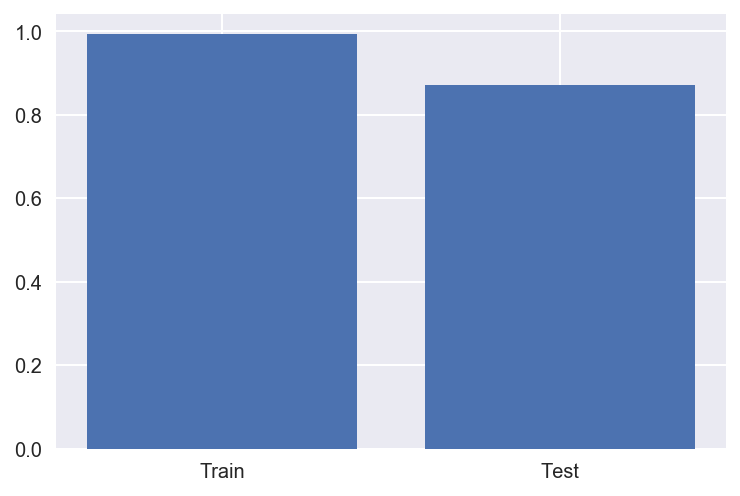

In [16]:
# def naver_movie_big():
    
import codecs
with codecs.open("ratings_train.txt", encoding='utf-8') as f:
    data = [line.split('\t') for line in f.read().splitlines()]
    data = data[1:]   # header 제외

X_b = list(zip(*data))[1]
y_b = np.array(list(zip(*data))[2], dtype=int)

import codecs
with codecs.open("ratings_test.txt", encoding='utf-8') as f:
    data_test = [line.split('\t') for line in f.read().splitlines()]
    data_test = data_test[1:]   # header 제외

X_test = list(zip(*data_test))[1]
y_test = np.array(list(zip(*data_test))[2], dtype=int)

model = clf.fit(X_b, y_b)

y_pred = model.predict(X_b)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_b, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_b, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_b, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_T = model.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_b, y_pred), accuracy_score(y_test, y_pred_T)
plt.bar(x,y)
plt.show()

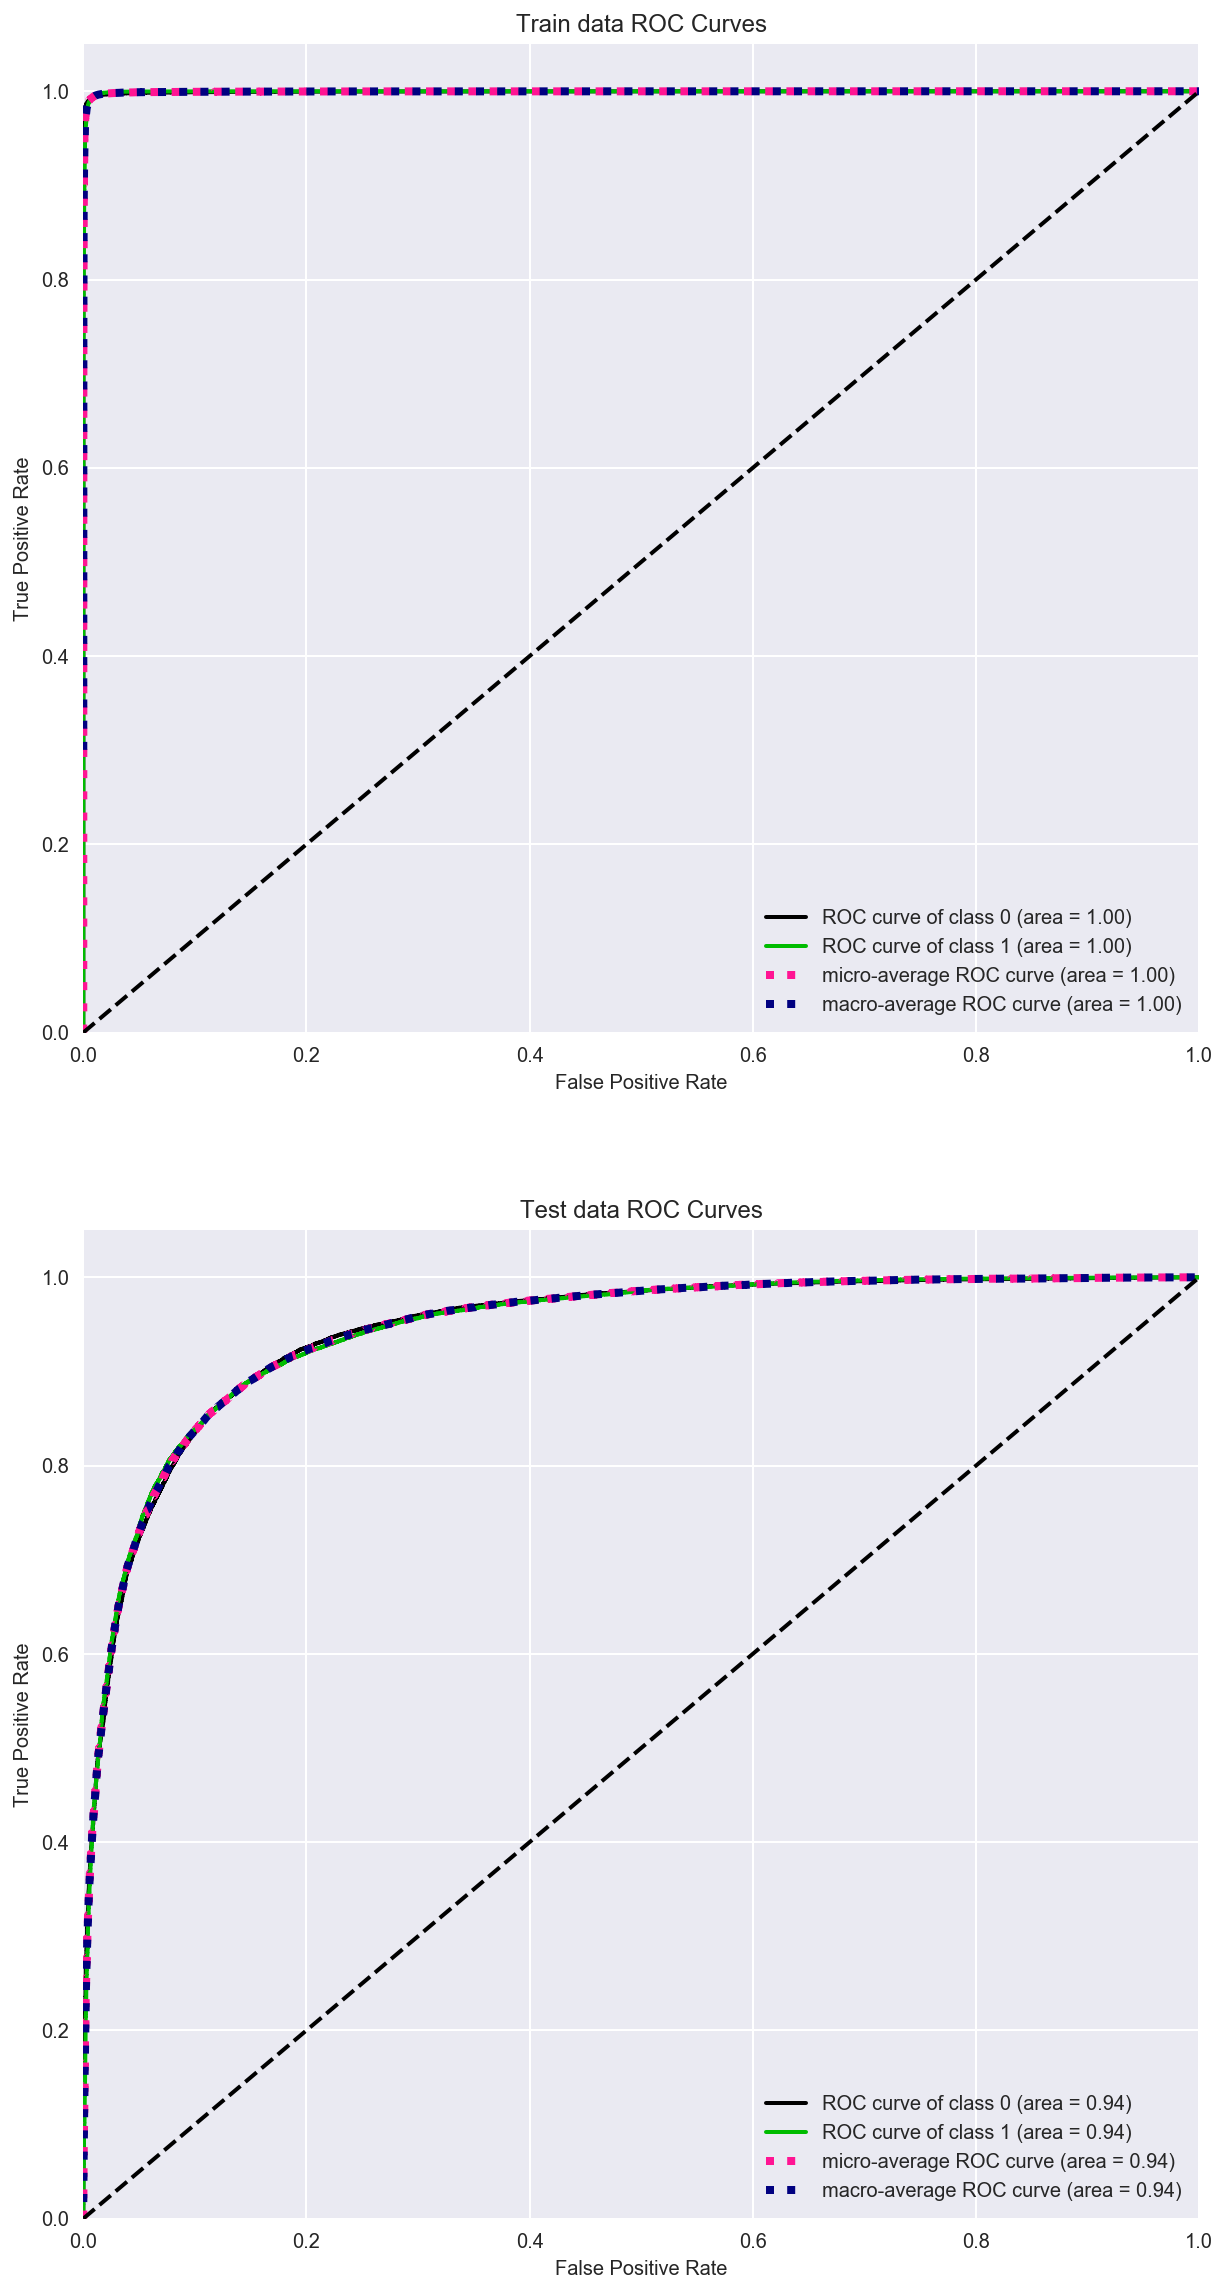

In [35]:
# ROC 민감도 체크

import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model.predict_proba(X_b)
y_probas_T = model.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_b, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### 문구 Test

Negative : 0 / Positive : 1

In [19]:
X_=pd.Series("추천")

y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.21641343 0.78358657]]
[1]


In [20]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 비추
[[0.94797006 0.05202994]]
[0]


---